# Plateforme d'Acquisition et de Traitement Automatisé des Textes
### Carnet d'expérimentation
---

## Sujet : Expérience ObsInfo2307
### Comparaison labelisation humaine et chatgpt

---

# Imports

In [1]:
cd ../..

/Volumes/Geek/Work/Patat


In [2]:
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

# Chargement Données

### Annotations Manuelles

In [3]:
import patat.util.gsheet

gs = patat.util.gsheet.GoogleSheet()

sheet_id = '1bEXdqyD7so-xm54_k-FMZchVVIcO8HjPSY1mA-wGW-w'
range_name = 'Data'

df_obsinfo = gs.read_df(sheet_id,range_name)

In [4]:
labels = [
    'infox',
    'lieux, dates et personnes',
    'faits',
    'opinions',
    'subjectif',
    'propos rapporté',
    'sources citées',
    'fausse nouvelle',
    'insinuation',
    'exagération',
    'titre décalé',
]

In [5]:
import numpy as np

In [6]:
def normalize(x):
    if x == '0':
        return 0.0
    elif x== '1':
        return 1.0
    else:
        return np.NaN

In [7]:
for label in labels:
    df_obsinfo[label]=df_obsinfo[label].apply(normalize)

In [8]:
df_obsinfo['url_h'] = df_obsinfo['url_labelizer'].apply(lambda s: s[-40:])

### Annotations ChatGpt

In [9]:
import patat.util.gsheet

gs = patat.util.gsheet.GoogleSheet()

sheet_id = '1cfuBc61rK7BlNog19Aq7atqlau8GfV8a3B3b5QzH8Xs'
range_name = 'Annotations'

df_gpt = gs.read_df(sheet_id,range_name)

In [10]:
for label in labels:
    df_gpt[label]=df_gpt[label].apply(normalize)

In [11]:
df_gpt['url_h'] = df_gpt['url_labelizer'].apply(lambda s: s[-40:])

# Moyennes et accords

In [12]:
df_mean = df_obsinfo.pivot_table(index='url_h',values=labels,aggfunc='mean')

In [13]:
df_accord = df_mean.apply(lambda x : abs(2*x-1))

## Performances ChatGpt - Moyenne
- On ne considère que les labels pour lesquels accord >= seuil_accord.

In [14]:
#seuil_accord = 1 # 8/8 observateurs
#seuil_accord = 0.75 # 7/8 observateurs
seuil_accord = 0.50 # 6/8 observateurs
#seuil_accord = 0.25 # 5/8 observateurs
#seuil_accord = 0 # toutes observations prises en compte

In [15]:
gpt_score = []
mean_pred = []
for index,row in df_gpt.iterrows():
    url_h=row['url_h']
    score_item = {'url_h':url_h}
    pred_item = {'url_h':url_h}
    for label in labels:
        if df_accord [label][index] >= seuil_accord:
            score_item[label]=row[label]-df_mean[label][url_h]
            pred_item[label] = round(df_mean[label][url_h])
    gpt_score.append(score_item)
    mean_pred.append(pred_item)
        

In [16]:
df_gpt_score = pd.DataFrame(gpt_score)
df_mean_pred = pd.DataFrame(mean_pred)

In [17]:
from sklearn import metrics

In [18]:
results = {}
for label in labels:
    indexes = df_mean_pred[label].notna()
    y_test = df_mean_pred[label][indexes]
    y_pred = df_gpt[label][indexes]  
    results[label] = {}
    results[label]['accuracy']=metrics.accuracy_score(y_test, y_pred)
    results[label]['precision']=metrics.precision_score(y_test, y_pred)
    results[label]['f1']=metrics.f1_score(y_test, y_pred)
    results[label]['recall']=metrics.recall_score(y_test, y_pred)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred,normalize='all')
    results[label]['false_positive']=cnf_matrix[0,1]
    results[label]['false_negative']=cnf_matrix[1,0]
    results[label]['count']=len(y_test)


In [19]:
pd.set_option('display.precision',3)

In [20]:
df_results = pd.DataFrame(results).T
df_results

,accuracy,precision,f1,recall,false_positive,false_negative,count
infox,0.714,1.000,0.412,0.259,0.000,0.286,70.0
"lieux, dates et personnes",0.800,1.000,0.887,0.798,0.000,0.200,90.0
faits,0.948,0.989,0.973,0.958,0.010,0.041,97.0
opinions,0.769,0.953,0.820,0.719,0.026,0.205,78.0
subjectif,0.776,0.963,0.754,0.619,0.013,0.211,76.0
propos rapporté,0.767,0.167,0.105,0.077,0.068,0.164,73.0
sources citées,0.475,1.000,0.436,0.279,0.000,0.525,59.0
fausse nouvelle,0.818,1.000,0.125,0.067,0.000,0.182,77.0
insinuation,0.593,1.000,0.312,0.185,0.000,0.407,54.0
exagération,0.690,0.857,0.522,0.375,0.028,0.282,71.0


/var/folders/fr/mhrqmk5n1xs49b7jl3tgs2r00000gn/T/ipykernel_55097/1796772995.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


[Text(0, 0, 'infox'),
 Text(1, 0, 'lieux, dates et personnes'),
 Text(2, 0, 'faits'),
 Text(3, 0, 'opinions'),
 Text(4, 0, 'subjectif'),
 Text(5, 0, 'propos rapporté'),
 Text(6, 0, 'sources citées'),
 Text(7, 0, 'fausse nouvelle'),
 Text(8, 0, 'insinuation'),
 Text(9, 0, 'exagération'),
 Text(10, 0, 'titre décalé')]

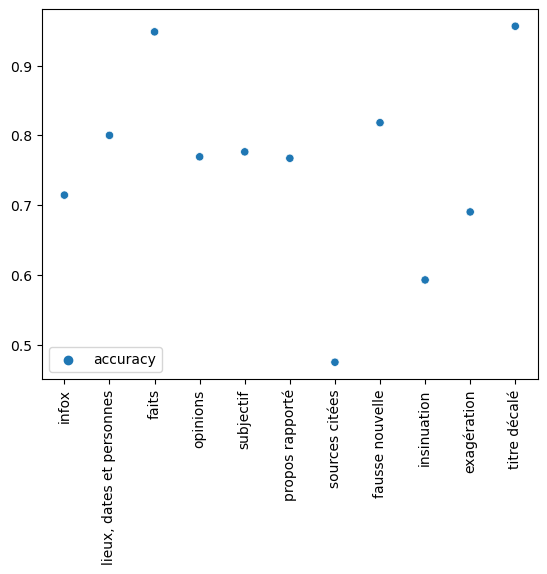

In [21]:
plot = sns.scatterplot(df_results[['accuracy']])
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

/var/folders/fr/mhrqmk5n1xs49b7jl3tgs2r00000gn/T/ipykernel_55097/774940859.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=90)


[Text(0, 0, 'infox'),
 Text(1, 0, 'lieux, dates et personnes'),
 Text(2, 0, 'faits'),
 Text(3, 0, 'opinions'),
 Text(4, 0, 'subjectif'),
 Text(5, 0, 'propos rapporté'),
 Text(6, 0, 'sources citées'),
 Text(7, 0, 'fausse nouvelle'),
 Text(8, 0, 'insinuation'),
 Text(9, 0, 'exagération'),
 Text(10, 0, 'titre décalé')]

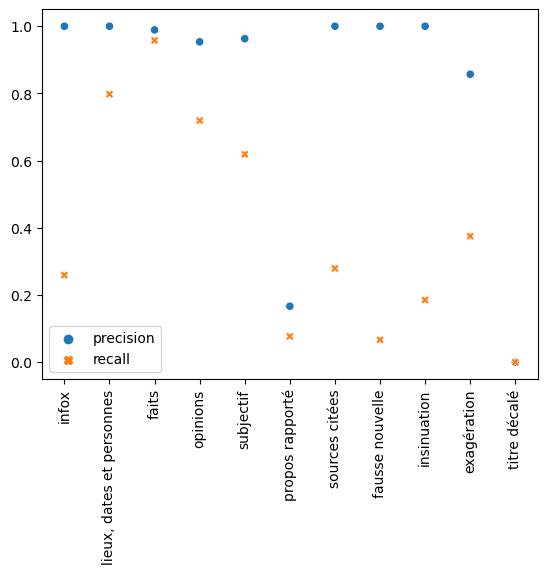

In [22]:
plot = sns.scatterplot(df_results[['precision','recall']])
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

/var/folders/fr/mhrqmk5n1xs49b7jl3tgs2r00000gn/T/ipykernel_55097/1999770200.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_xticklabels(plot.get_xticklabels(), rotation=45)


[Text(0, 0, 'infox'),
 Text(1, 0, 'lieux, dates et personnes'),
 Text(2, 0, 'faits'),
 Text(3, 0, 'opinions'),
 Text(4, 0, 'subjectif'),
 Text(5, 0, 'propos rapporté'),
 Text(6, 0, 'sources citées'),
 Text(7, 0, 'fausse nouvelle'),
 Text(8, 0, 'insinuation'),
 Text(9, 0, 'exagération'),
 Text(10, 0, 'titre décalé')]

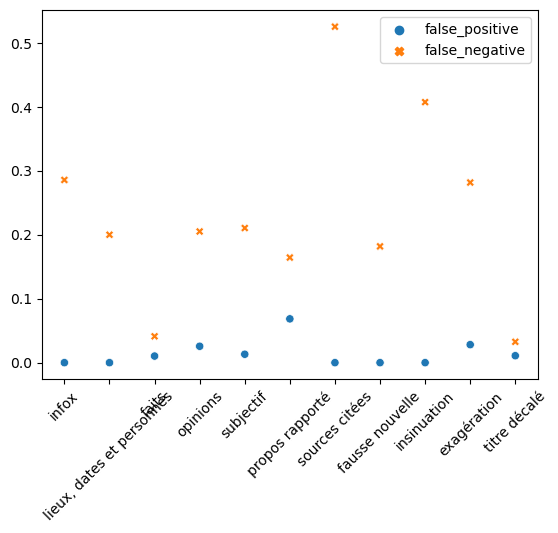

In [23]:
plot = sns.scatterplot(df_results[['false_positive','false_negative']])
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)